# Introduction

This is an implementation of the Bert Model for Sequence classification.
The model was taken from transformers library of Hugging Face.
It is trained to classify tweets according to five categories.
Here we use the base-cased version of BERT.

**Importing**

In [1]:
import torch
# Run on GPU if possile
if torch.cuda.is_available():        
    device = torch.device('cuda')
    print('Use GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available!')
    device = torch.device('cpu')

Use GPU: Tesla K80


In [2]:
!pip install transformers
!pip install -U -q PyDrive 

# Use this client to access datafiles from Google Drive
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth
from oauth2client.client import GoogleCredentials 

     |████████████████████████████████| 4.0 MB 9.8 MB/s 
     |████████████████████████████████| 880 kB 35.6 MB/s 
     |████████████████████████████████| 6.6 MB 35.6 MB/s 
     |████████████████████████████████| 596 kB 36.8 MB/s 
     |████████████████████████████████| 77 kB 4.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0a56604bcc2bcd99a25fbbccd2e58a54045e7f0d17eff5e199c915704321845d
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**Prepare the Data**

In [3]:
import pandas as pd

# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1scaBYdCD5ud3OimQC15CGgYCfDVEBmvC/view?usp=sharing'

# to get the id part of the file 
id = link.split("/")[-2] 
  
downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('Corona_NLP_train.csv')   

# Encoding 'latin-1' tolerates a wider range of Twitter vocabulary compared to utf-8  
df = pd.read_csv('Corona_NLP_train.csv',encoding='latin-1') 
# Have a look at the data with format 3798*6
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [4]:
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


**Preprocess the data**

In [5]:
# Label names will be transformed to numbers, so they can be computed as tensors 
# For targetting tensors should correspond to 0-n-1 labels 
def to_sentiment(Sentiment):
  if Sentiment =='Extremely Negative':
    return 4
  elif Sentiment == 'Negative':
    return 3
  elif Sentiment == 'Neutral':
    return 2
  elif Sentiment == 'Positive':
    return 1
  else:
    return 0

df['Sentiment'] = df.Sentiment.apply(to_sentiment)

In [6]:
import re

# Replace all hashtags by the written name and url adresses by 'url'
df.OriginalTweet = df.OriginalTweet.replace(to_replace='#',value='hashtag ',regex=True)
df.OriginalTweet = df.OriginalTweet.replace(to_replace='\n+|\t+',value=' ',regex=True)
df.OriginalTweet = df.OriginalTweet.replace(to_replace=r'https://.+',value='url',regex=True)

# Check success
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv url,2
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the hash...",4
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,1
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,1
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,2
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,1
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",3


In [7]:
import numpy as np

# Get the lists of sentences and their labels.
sentences = df.OriginalTweet.values
labels = df.Sentiment.values
labels = np.array(labels)

# Classes of labels
classes = ['Extremely Positive','Positive','Neutral','Negative','Extremely Negative']

In [8]:
# Inspect samples to classify

def inspect_data(num:int):
  for i in range(num):
    s = np.random.randint(0,len(sentences)-1)
    print(f'Sample {i+1}: {sentences[s]}')
  pass

inspect_data(10)

Sample 1: With all these monumental disruptions to daily life, people are increasingly turning to online shopping. Accompanying this uptick in online activity is an increase in cyber fraud. Find out more -&gt; url
Sample 2: COVID 19 has sent swaths of the U S food system into overdrive as manufacturers distributors grocers and food safety regulators try to meet demand from consumers stockpiling food and other essentials Experts say supplies are ample and inspections are continuing as normal
 But we have over-70s still going to the supermarket and joggers getting spot fines, so all good.
 url
Sample 5: Cash is kingÂand now more so than ever. url
Sample 6: If you see price gouging in Mo related to COVID 19 here s link to where it can be reported said several investigations are already underway
Sample 7: PSA: If youÂre not elderly or have an underlying health condition (like an autoimmune disease) please stop taking up grocery store pickup times. Those of us who rely on those services n

Average length: 197
Max sentence length: 494


Text(0, 0.5, '')

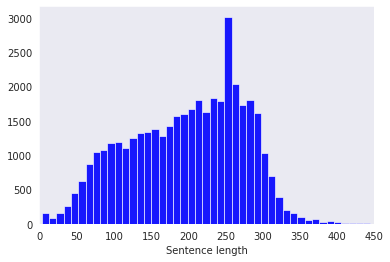

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Important values for our data

len_list = [len(i) for i in sentences]
average_len = 0
for i in len_list:
  average_len += i
average_len = round(average_len/len(len_list))
print('Average length:',average_len)

max_len = max(len_list)
print('Max sentence length:', max_len)

# Encoding length 
length = average_len + 80

sns.set_style('dark')
sns.histplot(len_list,alpha=0.9,color='blue',bins=50)
plt.xlim([0,450])
plt.xlabel('Sentence length')
plt.ylabel('')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, "['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']")

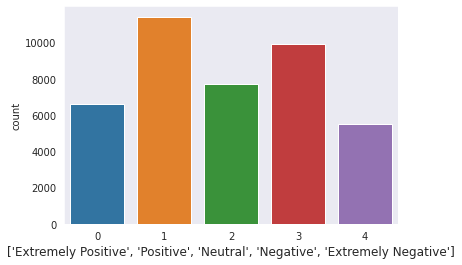

In [10]:
# Label distribution
sns.countplot(labels)
plt.xlabel(classes,fontsize='large')

**Bert Tokenizer**

In [11]:
from transformers import BertTokenizer
# Load the BERT tokenizer
# We make use of Cased Version,as tweets likely express differences in meaning for lower and upper case
# ANGRY!! & angry
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Under the hood of tokenization
text = tokenizer.encode_plus(sentences[4],return_token_type_ids=True)
print('Original text: {:}'.format(sentences[4]))
print('text tokens: {:}'.format(tokenizer.tokenize(sentences[4])))
print('Input_ids: {:}'.format(text['input_ids']))

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

 hashtag CoronavirusFrance hashtag restezchezvous hashtag StayAtHome hashtag confinement url
text tokens: ['Me', ',', 'ready', 'to', 'go', 'at', 'supermarket', 'during', 'the', 'has', '##hta', '##g', 'CO', '##VI', '##D', '##19', 'outbreak', '.', 'Not', 'because', 'I', "'", 'm', 'paranoid', ',', 'but', 'because', 'my', 'food', 'stock', 'is', 'litter', '##aly', 'empty', '.', 'The', 'has', '##hta', '##g', 'co', '##rona', '##virus', 'is', 'a', 'serious', 'thing', ',', 'but', 'please', ',', 'don', "'", 't', 'panic', '.', 'It', 'causes', 'shortage', '.', '.', '.', 'has', '##hta', '##g', 'Co', '##rona', '##virus', '##F', '##rance', 'has', '##hta', '##g', 'rest', '##ez', '##che', '##z', '##vous', 'has', '##hta', '##g', 'Stay', '##A', '##t', '##H', '##ome', 'has', '##hta', '##g', 'confinement', 'u', '##rl']
Input_ids: [101, 2508, 117, 2407, 1106, 1301, 1120, 20247, 1219, 1103, 1144, 26489, 1403, 18732, 23314, 2137, 16382, 8010, 119, 1753, 1272, 146, 112, 182, 24105, 117, 1133, 1272, 1139, 2094,

In [12]:
from tqdm import tqdm 
# Get tokenized ids of inputs in torch tensors
input_ids = []

for sample in tqdm(sentences):
  coding = tokenizer.encode_plus(
      sample,
      max_length=length,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='np'
  )
  input_ids.append(coding['input_ids'][0])

# Make attention masks
# For each tweet in input_ids create list of same length with values 1 for present token and 0 else
attention_masks = []
for i in input_ids:
  appen = [1 if (id>0) else 0 for id in i]
  # List of lists
  attention_masks.append(appen)

# Array of arrays
input_ids = np.array(input_ids)


  0%|          | 0/41157 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 41157/41157 [01:02<00:00, 659.88it/s]


**Create Dataloader**

In [13]:
from sklearn.model_selection import train_test_split
# Split Data into test and validation set 
# Recommended split is 20:80
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.2)

# Convert to input compatible type: tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels,dtype=torch.long)
validation_labels = torch.tensor(validation_labels,dtype=torch.long)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
# Create DataLoader our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create DataLoader for validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

**Initialize model**

In [15]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Loading our model  
model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased', 
    num_labels = 5, 
    output_attentions = False,
    output_hidden_states = False, 
)
# Move model to GPU
model.cuda()

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [16]:
# Define Parameters for training:
# Using AdamW as optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # learning_rate alpha, make it high as this is new classification task
                  eps = 1e-8 # epsilon for stability, leave it at default
                  #correct_bias = False,
                )

# Greater than 5 causes huge training time 
epochs = 4
# Number of training steps is number of batches * number of epochs
training_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = training_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


**Begin Training**

In [17]:
# Get accuracy calculates the accuracy of predictions vs the true labels 
def get_accuracy(preds,labs):
  val_1 = np.argmax(preds,axis=1).flatten()
  val_2 = labs.flatten()
  return np.sum(val_1==val_2)/len(val_2),val_1

In [ ]:
 # Store history of learning
loss_values = []
acc_values = []

for i in range(epochs):
    print(f'\n--------- Epoch {i+1}/{epochs} ---------')
    print('\nTraining...')

    # Reset the total loss for this epoch.
    epoch_loss = 0

    # Tell berta to train (differs from evaluation mode where outputs are effected)
    model.train()
    
    for batch in tqdm(train_dataloader,desc='Progress',ncols=100):
        # Get data from Dataloader
        # Move it to GPU
        i0 = batch[0].to(device)
        i1 = batch[1].to(device)
        i2 = batch[2].to(device)

        # Set gradient to zero for each run through loop
        model.zero_grad()        

        # Feed data to model
        outputs = model(i0, token_type_ids=None, attention_mask=i1, labels=i2)
        
        # outputs returns a tuple which includes the loss (for targets)
        # Extract the loss for this batch
        loss = outputs[0]
        epoch_loss += loss.item()

        # For learning we  
        # Calculate the gradient
        # Normalize it by clipping
        # Apply the gradient due to optimizers parameters
        # Update schedulers leraning rate

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Average loss by len of data
    training_loss = epoch_loss / len(train_dataloader)    
    
    # Store value          
    loss_values.append(training_loss)

    print('Training loss : {0:.2f}'.format(training_loss))
        

    print('Validation phase Epoch:{:}'.format(i+1))
    # Set berta to evaluation mode
    model.eval()

    # Variables for final measurement
    accuracy = 0
    batch_step = 0
    
    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader,desc='Progress',ncols=100):

        e0 = batch[0].to(device)
        e1 = batch[1].to(device)
        e2 = batch[2].to(device)
        
        # No need for calculating gradient as this is evaluation mode
        with torch.no_grad():        
            outputs = model(e0, token_type_ids=None, attention_mask=e1)
        
        # Returns the activations for the last layer
        # We have 5 labels
        # Move data to cpu & feed to accuracy fun
        logits = outputs[0]
        pred_labels = logits.detach().cpu().numpy()
        real_labels = e2.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        batch_acc,val1 = get_accuracy(pred_labels, real_labels)
        
        # Accumulate the total accuracy.
        accuracy += batch_acc
        # Track the number of batches
        batch_step += 1

    # Report final accuracy
    acc = accuracy/batch_step
    acc_values.append(acc)

    print(' Accuracy for Validation : {0:.2f}'.format(acc))

print('~'* 42)


--------- Epoch 1/4 ---------

Training...


Progress:  12%|██████                                            | 124/1029 [06:00<43:42,  2.90s/it]

In [ ]:
# plot acc_values & loss_values
import matplotlib.pyplot as plt
import seaborn as sns 

loss_val = [0.45,0.27,0.16,0.11]
acc_val = [0.84,0.84,0.85,0.85]
# acc_values
# loss_values

plt.plot(loss_val, label='train accuracy')
plt.plot(acc_val, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
best_score= max(acc_values)
best_score

In [ ]:
# Save model to GDrive
from google.colab import drive
drive.mount('/content/gdrive')

best_score = max(acc_values)
best_score = round(best_score,3)

model_save_name = f'berta_{best_score}.pt'
path = f'/content/gdrive/MyDrive/berta/{model_save_name}' 
torch.save(model.state_dict(), path)

**Load Prediction Data**

In [ ]:
# Load file
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1m_Lm9iywU19d1Kl0TVExMZgvs0Qylsvs/view?usp=sharing'

# Testset 
# https://drive.google.com/file/d/1m_Lm9iywU19d1Kl0TVExMZgvs0Qylsvs/view?usp=sharing

# to get the id part of the file 
id = link.split("/")[-2] 
  
downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('Corona_NLP_test.csv')   
  
df_test = pd.read_csv('Corona_NLP_test.csv',encoding='latin-1') 

In [ ]:
df_test.head()

In [ ]:
# Same preprocessing as before

df_test['Sentiment'] = df_test.Sentiment.apply(to_sentiment)

# Replace all hashtags by the written name and url adresses by 'url'
df_test.OriginalTweet = df_test.OriginalTweet.replace(to_replace='#',value='hashtag ',regex=True)
df_test.OriginalTweet = df_test.OriginalTweet.replace(to_replace='\n+|\t+',value=' ',regex=True)
df_test.OriginalTweet = df_test.OriginalTweet.replace(to_replace=r'https://.+',value='url',regex=True)

# Check success
df_test.head(10)

In [ ]:
# Get Data
sentences = df_test.OriginalTweet.values
labels = df_test.Sentiment.values

# Get tokenized ids of inputs in torch tensors
input_ids = []

for sample in sentences:
  coding = tokenizer.encode_plus(
      sample,
      max_length=length,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt'
  )
  input_ids.append(np.array(coding['input_ids'][0]))


# Make attention masks manually
attention_masks = []
for i in input_ids:
    am = [int(token_id > 0) for token_id in i]
    attention_masks.append(am)


input_ids = np.array(input_ids)
labels = np.array(labels)
# type(attention_mask) = list with list

**Prepare the dataloader**

In [ ]:
# Convert to tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32  
# Create DataLoader
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = RandomSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

**Run model on prediction data**

In [ ]:
def eval_score(preds,labs):
  compared = 0
  absolute = 0
  list_labels = []
  for s,i in enumerate(preds):
    pval = np.argmax(i,axis=1)
    lval = labs[s]
    list_labels.append(pval)
    compared += np.sum(pval==lval)/32
    absolute += np.sum(pval==lval)
  return compared/119,absolute, list_labels

In [ ]:
# Set model to eavluation mode
model.eval()

# For storing results
predictions = []
real_labels = []
step_size = 0

for batch in tqdm(prediction_dataloader,desc='Progress',ncols=100):
  p0 = batch[0].to(device)
  p1 = batch[1].to(device)
  p2 = batch[2].to(device)

  # Calculate no gradient for evaluation
  with torch.no_grad():
      outputs = model(p0, token_type_ids=None, attention_mask=p1)
  logits = outputs[0]
  # Convert values to numpy arrays for comparison
  # Move logits and labels to
  logits = logits.detach().cpu().numpy()
  label_ids = p2.to('cpu').numpy()
  predictions.append(logits)
  real_labels.append(label_ids)

score, absolute, list_l = eval_score(predictions,real_labels)
print(f'\nPrediction data scores with {absolute} of 3808: {round(score,3)}%!')

**Visualize**

In [ ]:
# Distribution of predictions
sns.set_style('dark')
pl = [i for ind in list_l for i in ind]
sns.countplot(pl)


In [ ]:
# Distribtuin of real labels
rl = [i for ind in real_labels for i in ind]
sns.countplot(rl)

In [ ]:
# Create a confusion matrix for visualization
def confuse(predictions,real_labels):
  # Turn nested tensors/arrays into list  
  v1 = [i for sublist in predictions for i in sublist]
  v2 = [i for sublist in real_labels for i in sublist]
  # Dataframe 
  data = {'predicted':v1,'actual':v2}
  df = pd.DataFrame(data, columns=['predicted','actual'])
  # confusion matrix 
  cm = pd.crosstab(df['predicted'],df['actual'],rownames=['Predicted'],colnames=['Actual'])
  sns.heatmap(cm,annot=True)
  plt.show()

confuse(predictions,real_labels)

In [ ]:
def predict_tweet(tweet):
  coding = tokenizer.encode_plus(
    tweet,
    max_length=length,#277
    add_special_tokens=True,
    return_token_type_ids=False,
    padding=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  input_ids = coding['input_ids'].to(device)
  attention_mask = coding['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  result = np.argmax(output)
  print('Output values:',output)
  print('Result:',result)

  print(f'Original Text : {tweet}')
  print(f'Sentiment : {classes[result]}')

text = 'I am in a very bad mood since the lockdown came in nothing is open any more... the worst thing that could happen!'
text_n = 'i dont really care about corona. As long as i have my playstation it is not too bad.'
text_p = 'Awesome, I love the situation. We can stay at Home all day every day!'

predict_tweet(text)

In [ ]:
# For loadining
from transformers import BertConfig,BertForSequenceClassification,BertTokenizer
import torch
from google.colab import drive

drive.mount('/content/gdrive')
config = BertConfig.from_pretrained('bert-base-cased', num_labels=5)
model = BertForSequenceClassification.from_pretrained('bert-base-cased', config=config)

if cuda.is_available():
  model.load_state_dict(torch.load('/content/gdrive/MyDrive/berta/berta_0.846.pt'))
else:
  model.load_state_dict(torch.load('/content/gdrive/MyDrive/berta/berta_0.846.pt',map_location=torch.device('cpu')))

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')